# LSTM-based model for time series data

This notebook provides tasks to analyze the flu-trends dataset using a Long Short-Term Memory (LSTM) model.

Required Python packages: pandas, numpy, matplotlib, darts, optuna

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import optuna
from darts import TimeSeries
from sklearn import metrics


c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 1: Data Preparation


- Load the dataset and split in into train/test/validation the same way you did yesterday
- Convert the dataset into darts' internal format and plot the data.
- Split the dataset into training and test sets and plot the curves.

In [2]:
test = pd.read_csv(os.path.join('..', 'data', 'interim', 'test.csv'))
train = pd.read_csv(os.path.join('..', 'data', 'interim', 'training.csv'))
val = pd.read_csv(os.path.join('..', 'data', 'interim', 'validation.csv'))

In [3]:
train_series = TimeSeries.from_dataframe(train, 'start_date', 'FluVisits')
test_series = TimeSeries.from_dataframe(test, 'start_date', 'FluVisits')
val_series = TimeSeries.from_dataframe(val, 'start_date', 'FluVisits')

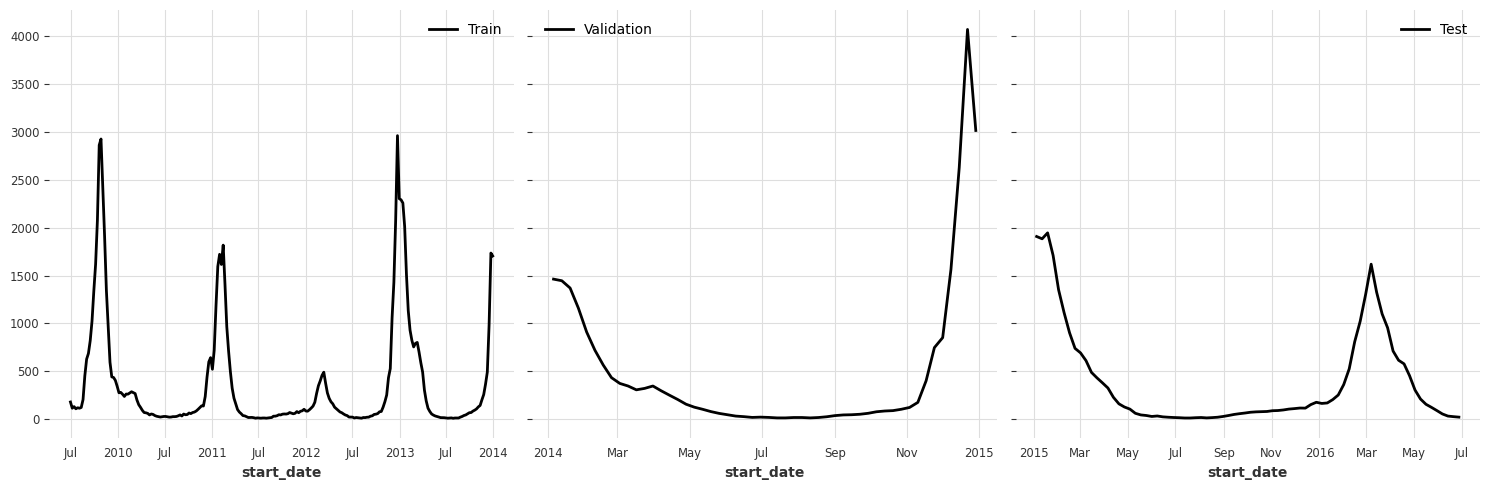

In [4]:
fig, ax = plt.subplots(1,3 , figsize=(15, 5), sharey=True)
train_series.plot(ax=ax[0], label='Train')
val_series.plot(ax=ax[1], label='Validation')
test_series.plot(ax=ax[2], label='Test')
plt.tight_layout()
plt.show()

## Task 2: Recap - XGBoost Model

To familiarize yourself with the new library, you should first look at its documentation. Then, train a XGBoost model on the data set. Just like yesterday. You can either use the default parameters, or you can use the ones you think work best. Compute the same metrics and compare the results.

In [5]:
from darts.models import RandomForest
from darts.models import XGBModel 

c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


## Random Forest model with default parameters

In [6]:
# first try with default parameters
rf_model = RandomForest(lags=8, output_chunk_length=2, n_estimators=100, random_state=42)
rf_model.fit(train_series)
pred_rf = rf_model.historical_forecasts(test_series, retrain=False)

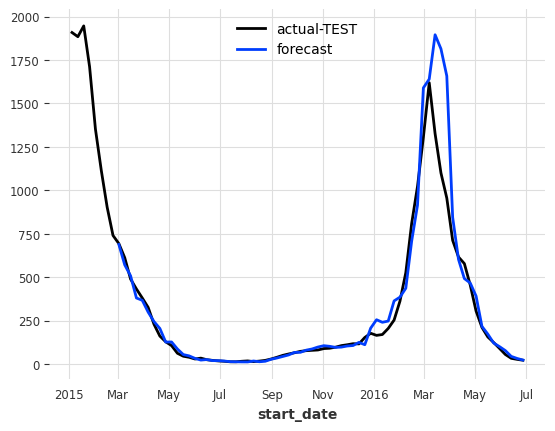

In [7]:
#visualize:
test_series.plot(label='actual-TEST')
pred_rf.plot(label='forecast')
plt.legend()
plt.show()

In [8]:
#evaluate:
test_series_skipped = test_series[8:]
MAPE = metrics.mean_absolute_percentage_error(test_series_skipped.values(), pred_rf.values())
R2 = metrics.r2_score(test_series_skipped.values(), pred_rf.values())
mse = metrics.mean_squared_error(test_series_skipped.values(), pred_rf.values())
print(f'MAPE: {MAPE}, R2: {R2}, MSE: {mse}')

MAPE: 0.16671180143392797, R2: 0.8295376027265925, MSE: 21623.818192857143


## XGB Model with default parameters

In [9]:
# now with XGBoost default parameters
xgb_model = XGBModel(lags=8, output_chunk_length=2, random_state=42)
xgb_model.fit(train_series)
pred_xgb = xgb_model.historical_forecasts(test_series, retrain=False)

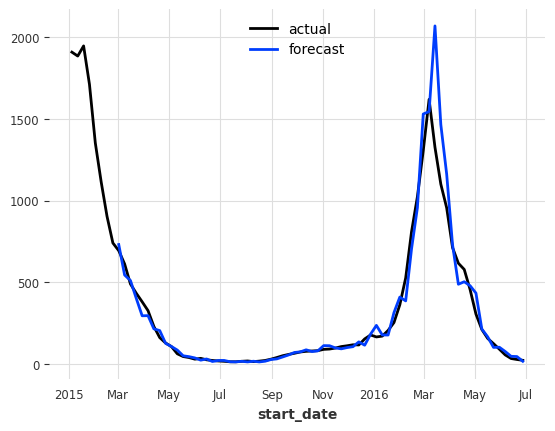

In [10]:
# visualize:
test_series.plot(label='actual')
pred_xgb.plot(label='forecast')
plt.legend()
plt.show()

In [11]:
# evaluate:
MAPE = metrics.mean_absolute_percentage_error(test_series_skipped.values(), pred_xgb.values())
R2 = metrics.r2_score(test_series_skipped.values(), pred_xgb.values())
mse = metrics.mean_squared_error(test_series_skipped.values(), pred_xgb.values())
print(f'MAPE: {MAPE}, R2: {R2}, MSE: {mse}')

MAPE: 0.17064187067741002, R2: 0.8994319694020613, MSE: 12757.44589098756


Compared to yesterdays results with default parameters, both models perform better. The RF model had a MAPE of 0.23, that was now reduced to 0.167. R2 was increased from 0.67 to 0.83 and MSE was reduced from 41498 to 21623.
The XGB model had a MAPE of 0.25 that was reduced to 0.17. R2 was increased from 0.599 to 0.899. MSE was reduced from 50538 to 12757.


## Task 3: Training an LSTM-based model

We will begin to work with neural networks for time series prediction. One type of neural network is a recurrent neural network (RNN). One of the most popular RNNs is the Long Short-Term Memory (LSTM) network.

Your task is to

- Use the RNN model from the Darts library.
- Train the model on the training set
- Make predictions on the test set
- Compute the same metrics as in the previous task and compare the results.

Unlike tree-based models, neural networks are more sensitive to the scale of the input data. Therefore, you should normalize the data before training the model. For example, you can use a min-max scaler that scales the data to the range [0, 1].

In [12]:
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler

In [24]:
# normalize using the Scaler from darts

scaler= Scaler()

train_scaled = scaler.fit_transform(train_series)
val_scaled = scaler.transform(val_series)
test_scaled = scaler.transform(test_series_skipped)

In [17]:
train_series.dtype
train_scaled.dtype

dtype('float64')

In [ ]:
rnn_model = RNNModel(model='LSTM', input_chunk_length=8, random_state=42)
rnn_model.fit(train_scaled)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\t

Epoch 0:   0%|          | 0/7 [00:00<?, ?it/s] 

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 59.38it/s, train_loss=0.00151] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 58.41it/s, train_loss=0.00151]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=8, random_state=42)

In [ ]:
rnn_pred = rnn_model.historical_forecasts(test_scaled, retrain=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## Evaluate RNN:

In [25]:
mape = metrics.mean_absolute_percentage_error(test_scaled.values(), rnn_pred.values())
r2 = metrics.r2_score(test_scaled.values(), rnn_pred.values())
mse = metrics.mean_squared_error(test_scaled.values(), rnn_pred.values())
print(f'MAPE: {mape}, R2: {r2}, MSE: {mse}')

MAPE: 0.26591334965145125, R2: 0.9435343480011943, MSE: 0.0008225261569184492


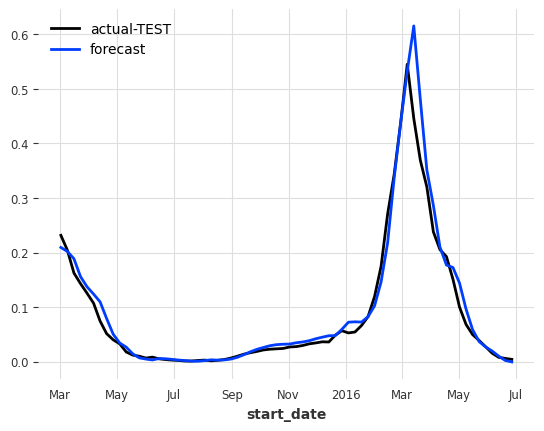

In [26]:
#visualize RNN:
test_scaled.plot(label='actual-TEST')
rnn_pred.plot(label='forecast')
plt.legend()
plt.show()

## Task 4: Optuna-based hyperparameter optimization with time series cross-validation

Today you will use Optuna to optimize the hyperparameters of the LSTM model. Compared to a grid search-based approach, Optuna is more efficient because it uses a more sophisticated algorithm to search the hyperparameter space. You will also use time series cross-validation to ensure that the model is evaluated on a realistic scenario.

Before you start working on this exercise, you should familiarize yourself with [Optuna](https://optuna.org/#key_features). Then you can take a look at the [darts documentation](https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html#hyperparameter-optimization-with-optuna) to see how to use Optuna with darts.

While it is not mandatory, we would like you to try to implement a class called RnnOptimization, which will handle the optimization and final training of the LSTM model. This class should have at least four methods:

- __init__(self, ...)
- objective(self, trial)
- optimize(self)
- train(self, best_params)

Note: Save your optuna study as a sqlite database to avoid losing the results.

In [ ]:
class RnnOptimization():
    def __init__(self, train, val):
        self.train = train
        self.val = val

    def objective(self, trial):
        # Suggest values for the hyperparameters using the trial object
        input_chunk_length = trial.suggest_int('input_chunk_length', 4, 20)
        hidden_size = trial.suggest_int('hidden_size', 10, 100)
        n_rnn_layers = trial.suggest_int('n_rnn_layers', 1, 3)
        dropout = trial.suggest_float('dropout', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        # Create and train the RNN model with the suggested hyperparameters
        model = RNNModel(
            model='LSTM',
            input_chunk_length=input_chunk_length,
            hidden_size=hidden_size,
            n_rnn_layers=n_rnn_layers,
            dropout=dropout,
            lr=lr,
            batch_size=batch_size,
            random_state=42
        )
        model.fit(self.train)

        # Make predictions on the validation set
        val_pred = model.historical_forecasts(self.val, retrain=False)

        # Calculate the MAPE on the validation set
        R2 = metrics.r2_score(self.val.values(), val_pred.values())

        return R2
    
    def optimize(self, n_trials):
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials)
        return study.best_params, study.best_value
    
    def train(self, best_params):
        best_model = RNNModel(
            model='LSTM',
            input_chunk_length=best_params['input_chunk_length'],
            hidden_size=best_params['hidden_size'],
            n_rnn_layers=best_params['n_rnn_layers'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            batch_size=best_params['batch_size'],
            random_state=42
        )
        best_model.fit(self.train)
        return best_model
    
    
        

## Task 5. Visualizing the Results of Hyperparameter Optimization

To understand the optimization process, you should visualize the results. You should create the following plots:

- A plot showing the trials and their results
- A plot showing the distribution of the results for each hyperparameter
- A plot showing the importance of each hyperparameter
- A plot showing a 3D surface plot of the two most important hyperparameters

## Task 6: Final Evaluation

Evaluate your model using the test data. Compute metrics (such as RMSE or MAPE) to compare the performance of your LSTM model with the RF and/or XGBoost models. Feel free to repeat the training and evaluation of the ARIMA, Random Forest, and XGBoost models if you want to change the optimization part or have a more consistent approach. Otherwise, you can use the results from the previous days. Visualize the results and discuss them.

## Optional tasks

Feel free to try anything that you find interesting (ask us for help if you need it). Otherwise, here are some suggestions:

- Try adding different features. Systematically analyze the impact of the additional feature on the model performance. Have a look at systematic feature selection: https://scikit-learn.org/stable/modules/feature_selection.html
- Have a look at the [Backtesting](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Backtesting:-simulate-historical-forecasting) section of the documentation. Perform an error and residual analysis for one of the models and discuss the results.
- If you did not do it yet, try to optimize the number of lags used in the model. Treat it as a hyperparameter.
- Does it make a difference if you use the GRU model instead of the LSTM model? Change the parameters accordingly and compare the results.